## Import all libraries

In [1]:
import os, sys

# set the working directory
sys.path.append(os.getcwd()+ os.sep + ".." + os.sep + "..")

import pandas as pd
import pycaret.classification as pc
from imblearn.over_sampling import SMOTEN
from sklearn import preprocessing
from sklearn.model_selection import  train_test_split

# import from ../script/data.py in scripts folder
from src.scripts.data import *

define some functions

In [2]:
def read_dataframes(folder_path):
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    dataframes = {file: pd.read_csv(os.path.join(folder_path, file)) for file in file_list}
    return dataframes


def get_common_columns(dataframes):
    common_columns = dataframes[list(dataframes.keys())[0]].columns
    for df in dataframes.values():
        common_columns = common_columns.intersection(df.columns)
    return common_columns


def preprocess_dataframes(dataframes, common_columns):
    merged_df = pd.DataFrame()
    for i, (file, df) in enumerate(dataframes.items()):
        df = df[common_columns]
        df.insert(0, "State", file.split(" ")[2])
        #df.insert(0, "State", i)
        merged_df = pd.concat([merged_df, df])
    return merged_df

Import and preprocess data

In [3]:

# Read dataframes from GYTS folder
dataframes = read_dataframes("../../data/raw/GYTS/")

# Find common columns in all dataframes
common_columns = get_common_columns(dataframes)
print(common_columns)

# Preprocess dataframes
merged_df = preprocess_dataframes(dataframes, common_columns)


# Rename columns
merged_df.rename(columns={"CR1": "Age"}, inplace=True)
merged_df["Age"] = merged_df["Age"].map(CR1_dict)

merged_df.rename(columns={"CR2": "Gender"}, inplace=True)
merged_df["Gender"] = merged_df["Gender"].map(CR2_dict)

merged_df["CR8"] = merged_df["CR8"].map(CR8_smoke_dict)
merged_df.rename(columns={"CR8": "Smoke"}, inplace=True)

merged_df.rename(columns={"OR45": "SmokingParents"}, inplace=True)
merged_df.rename(columns={"OR46": "SmokingFriends"}, inplace=True)
merged_df["SmokingFriends"] = merged_df["SmokingFriends"].map(OR46_dict)
merged_df.rename(columns={"OR1": "WorkingParents"}, inplace=True)
merged_df["WorkingParents"] = merged_df["WorkingParents"].map(OR1_dict)
merged_df.rename(columns={"CR22": "SeenSmokerInSchool"}, inplace=True)
merged_df["SeenSmokerInSchool"] = merged_df["SeenSmokerInSchool"].map({1: True, 2: False})
merged_df.rename(columns={"CR21": "SeenSmokerInPublicPlace"}, inplace=True)
merged_df["SeenSmokerInPublicPlace"] = merged_df["SeenSmokerInPublicPlace"].map(CR21_dict)
merged_df.rename(columns={"CR20": "SeenSmokerInEnclosedPlace"}, inplace=True)
merged_df["SeenSmokerInEnclosedPlace"] = merged_df["SeenSmokerInEnclosedPlace"].map(CR20_dict)
merged_df.rename(columns={"CR19": "SeenSmokerInHome"}, inplace=True)
merged_df["SeenSmokerInHome"] = merged_df["SeenSmokerInHome"].map(CR19_dict)


# Keep only the desired columns
merged_df = merged_df[["State", "Gender", "Age", "Smoke", "SmokingParents", "SmokingFriends", "WorkingParents",
                       "SeenSmokerInSchool", "SeenSmokerInPublicPlace", "SeenSmokerInEnclosedPlace",
                       "SeenSmokerInHome"]]

# Drop rows with missing values
merged_df = merged_df.dropna()

merged_df['SmokingFather'] = merged_df['SmokingParents'].apply(lambda x: True if OR45_dict[x] in ['Both', 'Father only'] else False)
merged_df['SmokingMother'] = merged_df['SmokingParents'].apply(lambda x: True if OR45_dict[x] in ['Both', 'Mother only'] else False)
merged_df = merged_df.drop(columns=['SmokingParents'])

merged_df['WorkingFather'] = merged_df['WorkingParents'].apply(lambda x: True if x in ['Both', 'Father only'] else False)
merged_df['WorkingMother'] = merged_df['WorkingParents'].apply(lambda x: True if x in ['Both', 'Mother only'] else False)
merged_df = merged_df.drop(columns=['WorkingParents'])

# Convert columns to categorical
merged_df['State'] = merged_df['State'].astype('category')
merged_df["Gender"] = merged_df["Gender"].astype('category')
merged_df["Age"] = merged_df["Age"].astype('category')
merged_df["SmokingFriends"] = merged_df["SmokingFriends"].astype('category')
merged_df["SeenSmokerInPublicPlace"] = merged_df["SeenSmokerInPublicPlace"].astype('category')
merged_df["SeenSmokerInEnclosedPlace"] = merged_df["SeenSmokerInEnclosedPlace"].astype('category')
merged_df["SeenSmokerInHome"] = merged_df["SeenSmokerInHome"].astype('category')

# Convert to boolean
merged_df["Smoke"] = merged_df["Smoke"].astype("bool")
merged_df["SeenSmokerInSchool"] = merged_df["SeenSmokerInSchool"].astype('bool')
merged_df['SmokingFather'] = merged_df['SmokingFather'].astype('bool')
merged_df['SmokingMother'] = merged_df['SmokingMother'].astype('bool')
merged_df['WorkingFather'] = merged_df['WorkingFather'].astype('bool')
merged_df['WorkingMother'] = merged_df['WorkingMother'].astype('bool')

# Save the preprocessed dataframe to a CSV file
merged_df.to_csv("../../data/processed/merged_GYTS.csv", index=False)

# Remove the 17 and older age group
# merged_df = merged_df[merged_df["Age"] != "17 years old or older"]

merged_df

Index(['FinalWgt', 'Stratum', 'PSU', 'CR1', 'CR2', 'CR5', 'CR6', 'CR7', 'CR8',
       'CR9', 'CR10', 'CR11', 'CR12', 'CR13', 'CR15', 'CR16', 'CR17', 'CR18',
       'CR19', 'CR20', 'CR21', 'CR22', 'CR23', 'CR25', 'CR30', 'CR31', 'CR32',
       'CR33', 'OR57', 'CR35', 'CR36', 'CR41', 'CR42', 'CR43', 'OR1', 'OR45',
       'OR46', 'OR49', 'OR55'],
      dtype='object')


,State,Gender,Age,Smoke,SmokingFriends,SeenSmokerInSchool,SeenSmokerInPublicPlace,SeenSmokerInEnclosedPlace,SeenSmokerInHome,SmokingFather,SmokingMother,WorkingFather,WorkingMother
49,Portugal,Female,15 years old,True,None of them,False,1 to 2 days,1 to 2 days,0 days,True,True,False,True
51,Portugal,Female,15 years old,True,Some of them,False,1 to 2 days,1 to 2 days,0 days,False,False,True,True
55,Portugal,Male,14 years old,False,None of them,False,3 to 4 days,1 to 2 days,0 days,True,True,False,True
111,Portugal,Female,15 years old,True,Some of them,False,3 to 4 days,1 to 2 days,0 days,True,True,False,True
122,Portugal,Male,14 years old,True,Some of them,False,3 to 4 days,1 to 2 days,1 to 2 days,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,Italy,Female,13 years old,False,Most of them,False,7 days,0 days,0 days,False,False,True,True
1675,Italy,Female,13 years old,False,Some of them,False,3 to 4 days,0 days,1 to 2 days,False,False,True,True
1677,Italy,Male,13 years old,False,All of them,True,3 to 4 days,1 to 2 days,1 to 2 days,False,False,True,True
1678,Italy,Male,13 years old,False,Some of them,True,0 days,0 days,1 to 2 days,True,False,True,True


Train and test model

In [4]:
# # # Correlation matrix
# # corr = merged_df_encoded.corr()
# # fig, ax = plt.subplots(figsize=(40, 30))
# # sns.heatmap(corr, annot=True, annot_kws={"size": 8}, linewidths=.5, ax=ax)
# # plt.savefig("./data/processed/correlation_matrix.svg")
# # # plt.show()

# # Split the data into train and test sets
# train, test = train_test_split(merged_df, test_size=0.2, random_state=42)
# test.reset_index(drop=True, inplace=True)

# # Split the train set into features and target
# X = train.drop(columns=["Smoke"])
# y = train["Smoke"]

# # Convert y values to categorical values
# lab = preprocessing.LabelEncoder()
# y = lab.fit_transform(y)

No Sampling

In [5]:
# y = pd.DataFrame(y, columns=["Smoke"])
# y.reset_index(drop=True, inplace=True)
# X.reset_index(drop=True, inplace=True)
# train = pd.concat([X, y] , axis=1)

Sampling

In [6]:
# # SMOTE Oversampling
# smote = SMOTEN()
# # smote = ADASYN()
# # smote = RandomUnderSampler()
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Convert array to dataframe
# y_resampled = pd.DataFrame(y_resampled, columns=['Smoke'])
# # y = pd.DataFrame(y, columns=['Smoke'])

# # remove index
# # X.reset_index(drop=True, inplace=True)
# # y.reset_index(drop=True, inplace=True)
# X_resampled.reset_index(drop=True, inplace=True)

# train = pd.concat([X_resampled, y_resampled], axis=1)
# # df_resampled = pd.concat([X, y], axis=1)

Comparing models

In [7]:
merged_df.reset_index(drop=True, inplace=True)

setup = pc.setup(data=merged_df,
                 target='Smoke',
                 index=False,
                 session_id=123,
                #  normalize=True,
                #  encoding_method=preprocessing.LabelEncoder()
                ordinal_features={
                     "SmokingFriends": OR46_dict.values(),
                     "SeenSmokerInPublicPlace": CR21_dict.values(),
                     "SeenSmokerInEnclosedPlace": CR20_dict.values(),
                     "SeenSmokerInHome": CR19_dict.values()
                 },
                #  fix_imbalance=True, fix_imbalance_method=SMOTEN(),
                transformation=True,
                remove_multicollinearity=True, multicollinearity_threshold=0.95,
                # max_encoding_ohe=0
                )

best = pc.compare_models(sort='MCC')

,Description,Value
0,Session id,123
1,Target,Smoke
2,Target type,Binary
3,Original data shape,"(20368, 13)"
4,Transformed data shape,"(20368, 37)"
5,Transformed train set shape,"(14257, 37)"
6,Transformed test set shape,"(6111, 37)"
7,Ordinal features,4
8,Categorical features,7
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8843,0.0000,0.4398,0.5379,0.4837,0.4193,0.4221,0.1730
nb,Naive Bayes,0.8050,0.0000,0.7114,0.3557,0.4741,0.3705,0.4041,0.1550
qda,Quadratic Discriminant Analysis,0.7986,0.0000,0.7034,0.3486,0.4643,0.3583,0.3928,0.1720
gbc,Gradient Boosting Classifier,0.8921,0.0000,0.3114,0.6258,0.4150,0.3631,0.3904,0.3630
ada,Ada Boost Classifier,0.8907,0.0000,0.3114,0.6131,0.4124,0.3592,0.3847,0.2470
lightgbm,Light Gradient Boosting Machine,0.8892,0.0000,0.3136,0.5965,0.4107,0.3561,0.3788,0.4230
lr,Logistic Regression,0.8915,0.0000,0.2830,0.6366,0.3909,0.3411,0.3754,1.3950
catboost,CatBoost Classifier,0.8874,0.0000,0.3131,0.5817,0.4065,0.3506,0.3714,3.0900
ridge,Ridge Classifier,0.8918,0.0000,0.2545,0.6631,0.3670,0.3206,0.3653,0.1650
xgboost,Extreme Gradient Boosting,0.8828,0.0000,0.3341,0.5411,0.4121,0.3512,0.3643,0.2590


Choosing best model

In [8]:
# model = pc.create_model('lda')

model = best

pc.predict_model(model)
pc.evaluate_model(model)
# pc.plot_model(model, plot='confusion_matrix')
# pc.plot_model(model, plot='auc')
# pc.plot_model(model, plot='pr')
# # pc.plot_model(model, plot='manifold')
# pc.plot_model(model, plot='boundary')

# # pc.plot_model(model, plot='feature')
# pc.plot_model(model, plot='feature_all',scale=3)


# tuned_model = pc.tune_model(model, optimize='MCC', choose_better = True)
# pc.predict_model(tuned_model)
# pc.evaluate_model(tuned_model)
# pc.plot_model(tuned_model, plot='confusion_matrix')
# pc.plot_model(tuned_model, plot='auc')
# pc.plot_model(tuned_model, plot='pr')
# pc.plot_model(tuned_model, plot='manifold')
# pc.plot_model(tuned_model, plot='boundary')
# pc.plot_model(tuned_model, plot='feature_all',scale=3)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.8845,0.8422,0.4045,0.5427,0.4635,0.4003,0.4058


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<Axes: xlabel='Age', ylabel='count'>

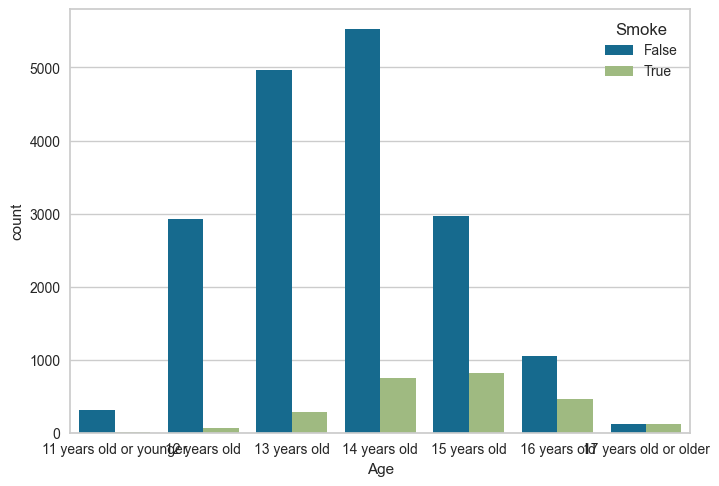

In [9]:
import seaborn as sns

# count smokers and non-smokers by age
sns.countplot(x='Age', hue='Smoke', data=merged_df)


In [10]:
# model = ExtraTreesClassifier(model)

pd.DataFrame({'Feature': pc.get_config('X_train').columns, 'Value' : abs(model.feature_importances_)}).sort_values(by='Value', ascending=False)

AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'feature_importances_'

Samples  Accuracy       AUC    Recall  \
Age                     Gender                                         
11 years old or younger Female      48    0.9375       0.5       0.0   
                        Male        51  0.960784       0.5       0.0   
12 years old            Female     490  0.971429  0.493776       0.0   
                        Male       409  0.977995  0.560006     0.125   
13 years old            Female     846  0.845154  0.646324  0.412698   
                        Male       735  0.888435  0.771662  0.641026   
14 years old            Female    1016  0.759843  0.697655  0.613636   
                        Male       904  0.769912  0.701284  0.611111   
15 years old            Female     572  0.708042  0.705088       0.7   
                        Male       541  0.731978  0.715564  0.688073   
16 years old            Female     199  0.572864  0.677842  0.907407   
                        Male       235  0.629787  0.704255  0.905405   
17 years old or older   Female      22  0.454545       0.5       1.0   
                        Male        43   0.55814       0.5       1.0   

                               Precision        F1     Kappa       MCC  \
Age                     Gender                                           
11 years old or younger Female       0.0       0.0       0.0       0.0   
                        Male         0.0       0.0       0.0       0.0   
12 years old            Female       0.0       0.0 -0.014193 -0.014344   
                        Male    0.333333  0.181818  0.172995  0.194769   
13 years old            Female  0.216667  0.284153  0.206674   0.22021   
                        Male    0.268817  0.378788  0.328588  0.366342   
14 years old            Female   0.29562  0.399015  0.271214  0.299484   
                        Male    0.284483  0.388235  0.269063  0.298937   
15 years old            Female  0.390698  0.501493  0.317783  0.344808   
                        Male    0.403226  0.508475  0.341059  0.364076   
16 years old            Female  0.379845  0.535519  0.247721  0.331208   
                        Male    0.455782  0.606335  0.322542  0.392042   
17 years old or older   Female  0.454545     0.625       0.0       0.0   
                        Male     0.55814  0.716418       0.0       0.0   

                               Selection Rate  
Age                     Gender                 
11 years old or younger Female            0.0  
                        Male              0.0  
12 years old            Female       0.012245  
                        Male         0.007335  
13 years old            Female       0.141844  
                        Male         0.126531  
14 years old            Female       0.269685  
                        Male         0.256637  
15 years old            Female       0.375874  
                        Male         0.343808  
16 years old            Female       0.648241  
                        Male         0.625532  
17 years old or older   Female            1.0  
                        Male              1.0

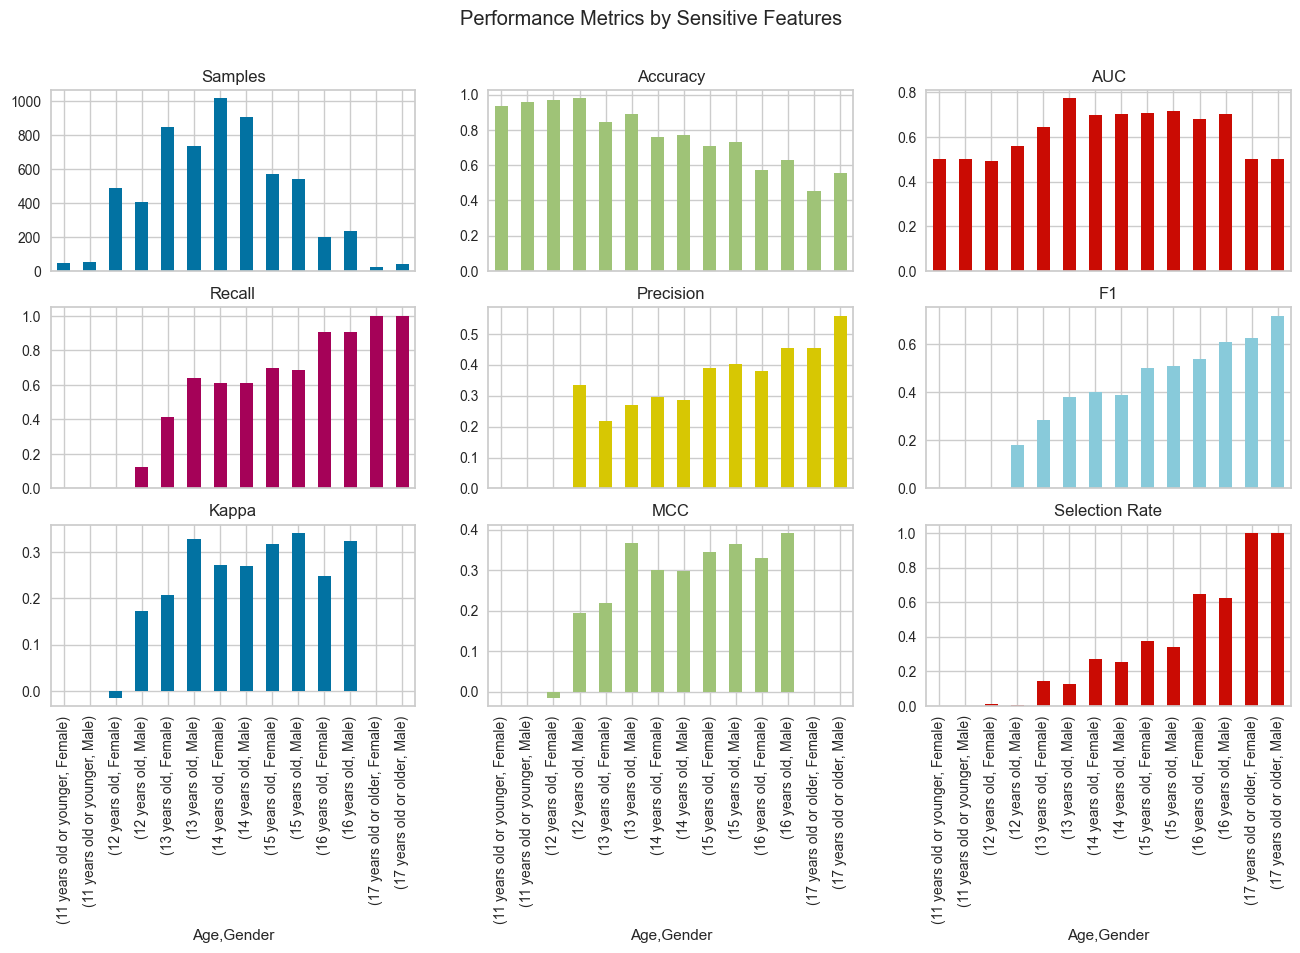

In [ ]:
pc.check_fairness(model, sensitive_features = ['Age', "Gender"])